# Automated Spam Filtering


# Abstract 
In this project, We try to filter Sms messages as Spam or Not Spam,by utilising a dataset from UCI Machine Learning Repository : https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

The goal of this project is to classify a text message with the labels Spam or Ham (Not Spam). This project is submitted by Sylvester Ranjith as part of Udacity's Machine Learning Nanodegree programme as a Capstone project.

Project includes installing the following Libraries

Install the Anaconda Python distribution, including Python itself.
Install the "natural language processing" TextBlob library

TextBlob is also available as a conda package. To install with conda, run

$ conda install -c https://conda.anaconda.org/sloria textblob

$ python -m textblob.download_corpora

For more details install from https://textblob.readthedocs.io/en/dev/install.html


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

/Users/sylvester/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Exploration

In [2]:
messages = [line.rstrip() for line in open('./data/SMSSpamCollection')]
print len(messages)

5574


The Dataset Contains around 5000 or more SMS messages.A collection of Texts is termed as a Corpus. 

In [3]:
#printing the first 10 messages of the SMS CORPUS
for message_no, message in enumerate(messages[:10]):
    print message_no, message

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

We observe that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.
This corpus will be our labeled training set. Using these ham/spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

![](http://www.astroml.org/sklearn_tutorial/_images/plot_ML_flow_chart_1.png)

In [4]:
#Using Pandas to access the data
messages = pandas.read_csv('./data/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print messages

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

In [5]:
#Aggregating Statistics
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4827
      unique                                               4518
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [6]:
#length of messages
messages['length'] = messages['message'].map(lambda text: len(text))
print messages.head()

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


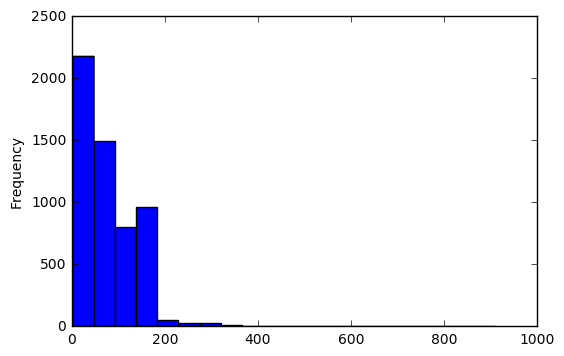

In [7]:

messages.length.plot(bins=20, kind='hist')

In [8]:
messages.length.describe()

count    5574.000000
mean       80.604593
std        59.919970
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [9]:
print list(messages.message[messages.length > 900])

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x116d35f90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1174711d0>], dtype=object)

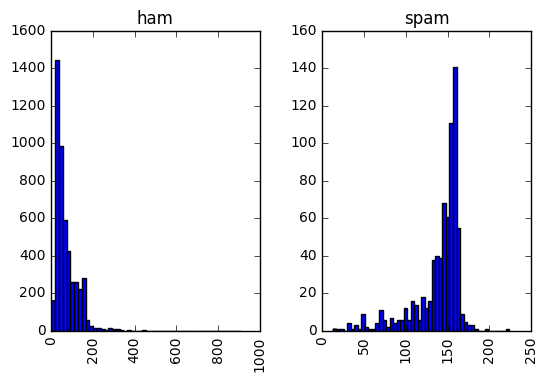

In [10]:
#difference in length between Spam and Ham messages
messages.hist(column='length', by='label', bins=50)

## Step 2: Data preprocessing

In this step we convert the raw messages (sequence of characters) into vectors (sequences of numbers).
The mapping is not 1-to-1; hence using the bag-of-words approach, where each unique word in a text is represented by one number.

In [11]:
#The following function Splits messages into individual words
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [12]:
#The original messages
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [13]:
#Tokenized version of texts
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [14]:
#Parts of speech Tagging
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[(u'Hello', u'UH'),
 (u'world', u'NN'),
 (u'how', u'WRB'),
 (u'is', u'VBZ'),
 (u'it', u'PRP'),
 (u'going', u'VBG')]

In [15]:
#Normalising the Texts into Lemmas
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

## Step 3: Data to vectors

Now we will convert each message, represented as a list of tokens into a vector that machine learning models can understand.
It involves three steps in the bag of words approach 

1.Counting the frequency of a word occurring in each message (term frequency)

2.Weighting the counts, so that frequent tokens get lower weight (inverse document frequency)

3.Normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus:


Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.
In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:
tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
counting the occurrences of tokens in each document.
normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.
In this scheme, features and samples are defined as follows:
each individual token occurrence frequency (normalized or not) is treated as a feature.
the vector of all the token frequencies for a given document is considered a multivariate sample.
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.
We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

Reference : http://scikit-learn.org/stable/modules/feature_extraction.html#the-bag-of-words-representation

In [16]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print len(bow_transformer.vocabulary_)

8874


In [17]:
message4 = messages['message'][3]
print message4

U dun say so early hor... U c already then say...


In [18]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 1158)	1
  (0, 1899)	1
  (0, 2897)	1
  (0, 2927)	1
  (0, 4021)	1
  (0, 6736)	2
  (0, 7111)	1
  (0, 7698)	1
  (0, 8013)	2
(1, 8874)


In [19]:
#number of Unique words reappearing twice 
print bow_transformer.get_feature_names()[6736]
print bow_transformer.get_feature_names()[8013]

say
u


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:


In [20]:
messages_bow = bow_transformer.transform(messages['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (5574, 8874)
number of non-zeros: 80272
sparsity: 0.16%


After counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer:


** TfidTransformer:** 
In information retrieval, tf–idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1]:8 It is often used as a weighting factor in information retrieval and text mining. The tf-idf value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

![](http://dovgalecs.com/blog/wp-content/uploads/2012/03/img131.gif)



In [21]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 8013)	0.305114653686
  (0, 7698)	0.225299911221
  (0, 7111)	0.191390347987
  (0, 6736)	0.523371210191
  (0, 4021)	0.456354991921
  (0, 2927)	0.32967579251
  (0, 2897)	0.303693312742
  (0, 1899)	0.24664322833
  (0, 1158)	0.274934159477


In [22]:
# IDF (inverse document frequency) of the word "u" in word "university"?
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

2.85068150539
8.23975323521


In [23]:
#transform the entire bag-of-words corpus into TF-IDF corpus at once
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5574, 8874)


## Step 4: Training a model, detecting spam

With messages represented as vectors, we train our spam/ham classifier. We start with the Naive Bayes Classifier

**In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features.**


In [24]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 12.7 ms, sys: 895 µs, total: 13.6 ms
Wall time: 16.7 ms


In [25]:
#classify a random message
print 'predicted:', spam_detector.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: ham
expected: ham


In [26]:
all_predictions = spam_detector.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [27]:
print 'accuracy', accuracy_score(messages['label'], all_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)
print '(row=expected, col=predicted)'

accuracy 0.969501255831
confusion matrix
[[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


We get an accuracy of 0.96 which is how accurate our naive bayes classifier classifies the texts into Spam and Ham when using the training set.This may be incorrect since we are testing the classifier on the same dataset that we trained the classifier on.Hence in the next step we will split the data into testing and training sets

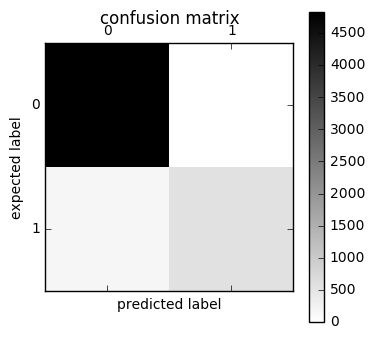

In [28]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [29]:
#From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



## Step 5: How to run experiments?

We now split the data into testing and training sets to check the correct accuracy of our classifier

In [30]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print len(msg_train)
print len(msg_test) 
print len(msg_train) + len(msg_test)

4459
1115
5574


The test size is partitioned to 20% of the entire dataset (1115 messages out of total 5574), and the training is the rest (4459 out of 5574).


In [31]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [32]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print scores

[ 0.95964126  0.96188341  0.9529148   0.94170404  0.93721973  0.95515695
  0.9529148   0.94843049  0.94394619  0.95730337]


In [33]:
print scores.mean() 
print scores.std()

0.951111502998
0.00768121445541


Compared to our previous score of 0.96 this is a bit worse at 0.95 hence we conclude that our prediction model can give an accuracy of 95% on the testing dataset

Naive Bayes is an example of a high bias - low variance classifier (aka simple and stable, not prone to overfitting). An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

->high bias = classifer is opinionated. Not as much room to change its mind with data, it has its own ideas. On the   other hand, not as much room it can fool itself into overfitting either (picture on the left).


->low bias = classifier more obedient, but also more neurotic. Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).


**Reference : http://blog.fliptop.com/blog/2015/03/02/bias-variance-and-overfitting-machine-learning-overview/

[![](http://radimrehurek.com/data_science_python/plot_bias_variance_examples_2.png)](http://www.astroml.org/sklearn_tutorial/practical.html#bias-variance-over-fitting-and-under-fitting)

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 634 ms, sys: 74.8 ms, total: 709 ms
Wall time: 45.2 s


<module 'matplotlib.pyplot' from '/Users/sylvester/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

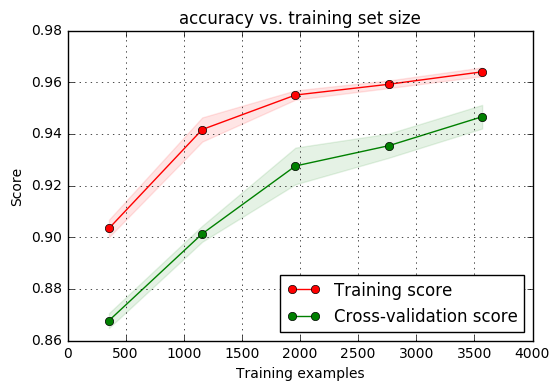

In [35]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

(We're effectively training on 64% of all available data: we reserved 20% for the test set above, and the 5-fold cross validation reserves another 20% for validation sets => 0.8*0.8*5574=3567 training examples left.)
Since performance keeps growing, both for training and cross validation scores, we see our model is not complex/flexible enough to capture all nuance, given little data. In this particular case, it's not very pronounced, since the accuracies are high anyway.
At this point, we have two options:
1.use more training data, to overcome low model complexity
2.use a more complex (lower bias) model to start with, to get more out of the existing data
Over the last years, as massive training data collections become more available, and as machines get faster, approach 1. is becoming more and more popular (simpler algorithms, more data). Straightforward algorithms, such as Naive Bayes, also have the added benefit of being easier to interpret (compared to some more complex, black-box models, like neural networks).

## Step 6: Performance Comparison 

We have achieved an accuracy of 95% using a naive bayes classifier,Let us compare it with the performance of various other classifiers such as Support Vector Machines.

One may think, Does IDF weighting have an effect on accuracy? Do we require extra processing cost of lemmatization (vs. just plain words)?


[![](http://radimrehurek.com/data_science_python/drop_shadows_background.png)](http://peekaboo-vision.blogspot.cz/2013/01/machine-learning-cheat-sheet-for-scikit.html)

In [ ]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [ ]:
%time nb_detector = grid.fit(msg_train, label_train)
print nb_detector.grid_scores_

In [ ]:
print nb_detector.predict_proba(["Hi mom, how are you?"])[0]
print nb_detector.predict_proba(["WINNER! Credit for free!"])[0]

The predict_proba returns the predicted probability for each class (ham, spam). In the first case, the message is predicted to be ham with > 99% probability, and spam with < 1%. So if forced to choose, the model will say "ham":

In [ ]:
print nb_detector.predict(["Hi mom, how are you?"])[0]
print nb_detector.predict(["WINNER! Credit for free!"])[0]
print svm_detector.predict(["Hey!!! you won 25000$ on a lottery click link to claim your reward"])[0]

In [ ]:
predictions = nb_detector.predict(msg_test)
print confusion_matrix(label_test, predictions)
print classification_report(label_test, predictions)

This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

**Using SVM(Support Vector Machines):**

In machine learning, support vector machines (SVMs, also support vector networks) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis.

**The advantages of support vector machines are:**
->Effective in high dimensional spaces.

->Still effective in cases where number of dimensions is greater than the number of samples.

->Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

->Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.
**The disadvantages of support vector machines include:**

If the number of features is much greater than the number of samples, the method is likely to give poor performances.
SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).


**Reference:http://scikit-learn.org/stable/modules/svm.html**

In [ ]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [ ]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print svm_detector.grid_scores_

In [ ]:
print svm_detector.predict(["Hi mom, how are you?"])[0]
print svm_detector.predict(["WINNER! Credit for free!"])[0]
print svm_detector.predict(["Hey!!! you won 25000$ on a lottery click link to claim your reward"])[0]

In [ ]:
print confusion_matrix(label_test, svm_detector.predict(msg_test))
print classification_report(label_test, svm_detector.predict(msg_test))

This is then the realistic predictive performance we can expect from our spam detection pipeline, when using SVMs.


# Conclusion:

Thus in this project we have built a Spam/Ham detector with two different approaches namely

1.**Naive Bayes Classifier with TFIDF** which results in an accuracy of 95% 

2.**Support Vector Machine** which results in an accuracy of 98% 